In [1]:
import time
import numpy as np
import pandas as pd
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_squared_error, accuracy_score, plot_confusion_matrix, f1_score
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix

import stellargraph as sg
from stellargraph import datasets
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    Node2VecNodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE, Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, optimizers, losses, metrics

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE, KMeansSMOTE, SMOTENC, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced

from collections import Counter, defaultdict
import multiprocessing
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
import utils

In [3]:
v_data, e_data, v_sets, e_sets, core_targets, ext_targets, core_testing = utils.load_for_jupyter()

Dataset already downloaded. Loading it from file system
LOADING DATA: 1.03 s
PREPROCESSING: 1.03 s


In [4]:
# Sort based on testingFlag
for i in v_sets:
    v_sets[i] = v_sets[i].sort_values('testingFlag')
    print(i,":")
    print(v_sets[i].testingFlag.value_counts())
    v_sets[i] = v_sets[i].drop('testingFlag', axis=1)

Account :
-1.0    126863
 0.0     13769
 1.0      1244
Name: testingFlag, dtype: int64
Address :
-1.0    28432
 0.0     1568
Name: testingFlag, dtype: int64
Customer :
-1.0    42127
 0.0    13650
 1.0      449
Name: testingFlag, dtype: int64
Derived Entity :
-1.0    27286
 0.0     3925
 1.0       63
Name: testingFlag, dtype: int64
External Entity :
-1.0    55207
 0.0     4757
 1.0       36
Name: testingFlag, dtype: int64


In [5]:
# Removing ExtendedCaseID:

# Test: let's leave this on:
for i in v_sets:
    v_sets[i] = v_sets[i].drop('ExtendedCaseGraphID', axis=1)

In [6]:
batch_size = 200
epochs = 15
num_samples = [8, 4]
dropout = 0.4
hinsage_layer_sizes = [32, 32]

In [7]:
G = sg.StellarDiGraph(v_sets, e_sets)

In [8]:
generator = HinSAGENodeGenerator(
    G, 
    batch_size, 
    num_samples,
    head_node_type="Account"
)

def make_hinsage():
    return HinSAGE(
    layer_sizes=hinsage_layer_sizes,
    activations=['relu', 'relu'],
    generator=generator, 
    bias=True,
    normalize="l2",
    dropout=dropout
)

hinsage = make_hinsage()

In [9]:
def run_deep_graph_infomax(base_model, generator, epochs):
    t0 = time.time()
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes(node_type="Account"))
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    # Train DGI
    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    es = EarlyStopping(monitor="loss", min_delta=0, patience=15)
    history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[es])
    sg.utils.plot_history(history)

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    t1 = time.time()
    print(f'Time required: {t1-t0:.2f} s ({(t1-t0)/60:.1f} min)')
    
    return x_emb_in, x_emb_out, model

Epoch 1/15
710/710 [==============================] - 77s 108ms/step - loss: 0.4074 
Epoch 2/15
710/710 [==============================] - 76s 107ms/step - loss: 0.29915s - loss: 0.3 - ETA: 5s - loss: 0. 
Epoch 3/15
710/710 [==============================] - 77s 109ms/step - loss: 0.2760
Epoch 4/15
710/710 [==============================] - 79s 111ms/step - loss: 0.2657
Epoch 5/15
710/710 [==============================] - 80s 112ms/step - loss: 0.2533
Epoch 6/15
710/710 [==============================] - 78s 110ms/step - loss: 0.2427
Epoch 7/15
710/710 [==============================] - 77s 109ms/step - loss: 0.2333
Epoch 8/15
710/710 [==============================] - 77s 109ms/step - loss: 0.2224
Epoch 9/15
710/710 [==============================] - 79s 112ms/step - loss: 0.2105
Epoch 10/15
710/710 [==============================] - 79s 111ms/step - loss: 0.2001
Epoch 11/15
710/710 [==============================] - 77s 108ms/step - loss: 0.1926
Epoch 12/15
710/710 [================

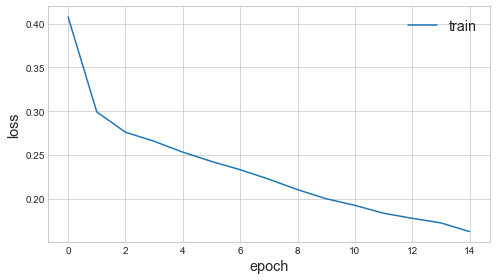

In [10]:
# Run Deep Graph Infomax

x_emb_in, x_emb_out, model = run_deep_graph_infomax(hinsage, generator, epochs=epochs)

In [11]:
# SPLIT

# Experiment: remove this now instead of before training
# problem: dimensionality inconsistency

for i in v_sets:
    v_sets[i] = v_sets[i].drop('ExtendedCaseGraphID', axis=1)
    
train_cv_set = v_sets['Account'][126863:126863+13769]

In [12]:
train_cv_set

,Revenue Size Flag,CoreCaseGraphID,source_degree,target_degree
node_id,,,,
15020041132,3,0.0,5.0,6.0
15020041134,4,0.0,3.0,8.0
15020058888,5,0.0,5.0,5.0
15020021707,4,3060.0,6.0,8.0
15020022245,3,2308.0,4.0,11.0
...,...,...,...,...
15020082878,5,0.0,2.0,9.0
15020028999,4,0.0,7.0,7.0
15020056211,1,1016.0,2.0,8.0


In [13]:
emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)
train_cv_embs = emb_model.predict(
    generator.flow(train_cv_set.index.values)
)
train_cv_embs_2d = pd.DataFrame(
    TSNE(n_components=2).fit_transform(train_cv_embs), 
    index=train_cv_set.index.values
)

In [14]:
# Coloring based on ExtendedCaseGraphID

# these are the training+cv indexes
node_ids = train_cv_set.index.values.tolist()

# these are the training+cv Extended case ID
ext_targets_2 = v_data.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID 

label_map = {l: i*10 for i, l in enumerate(np.unique(ext_targets_2), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets_2]

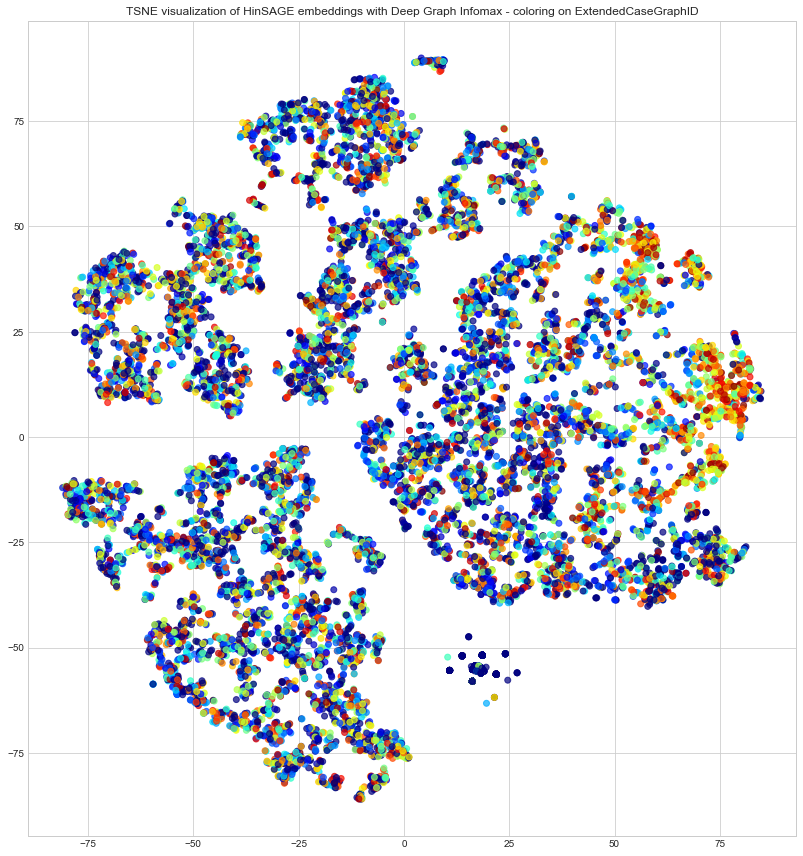

In [15]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    train_cv_embs_2d[0],
    train_cv_embs_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax - coloring on ExtendedCaseGraphID")
plt.show()

In [16]:
# account core case ID based coloring

# these are the training+cv core case IDs
ext_targets_5 = v_data.loc[[int(node_id) for node_id in node_ids]]['CoreCaseGraphID']

label_map = {l: i*100 for i, l in enumerate(np.unique(ext_targets_5), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets_5]

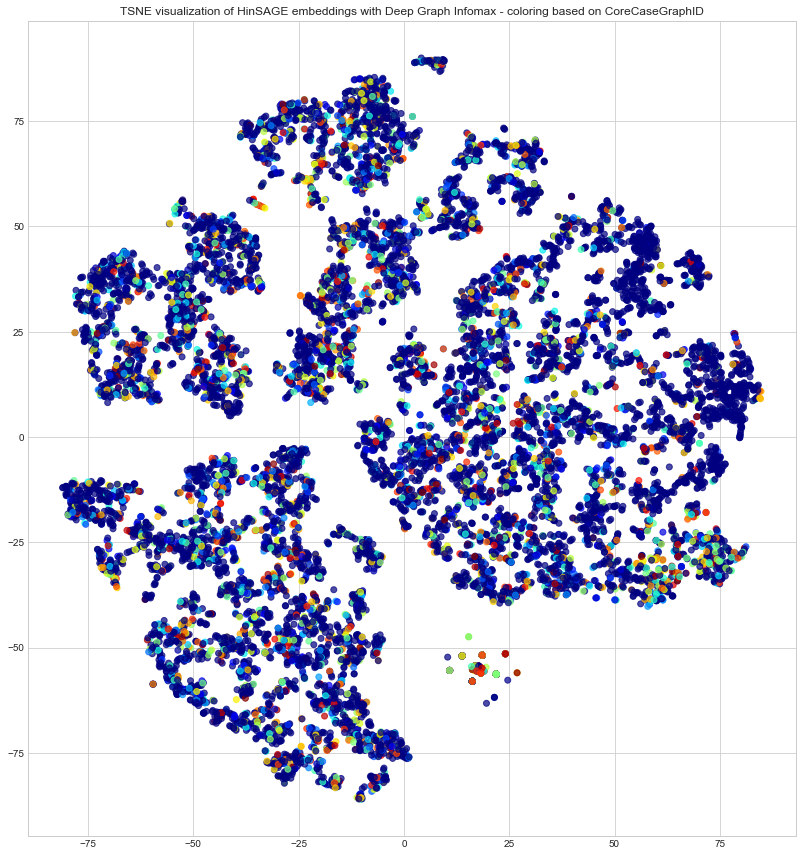

In [17]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(
    train_cv_embs_2d[0],
    train_cv_embs_2d[1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal")
plt.title("TSNE visualization of HinSAGE embeddings with Deep Graph Infomax - coloring based on CoreCaseGraphID")
plt.show()

In [18]:
# Fine tuning:



In [66]:
# very rudimentary and shitty splitting:

n_embs = train_cv_embs.shape[0]

train_set = train_cv_embs[:10000]
train_labels = np.ravel(pd.DataFrame(ext_targets_2.values[:10000]).fillna(0))

cv_set = train_cv_embs[-3769:]
cv_labels = np.ravel(pd.DataFrame(ext_targets_2.values[-3769:]).fillna(0))

In [67]:
###### CLASSIFY

In [68]:
sample_weights = np.ones(10000)
sample_weights[0] = 0.03

In [69]:
## TRY GRADIENT BOOSTING CLASSIFIER
classifier = AdaBoostClassifier()

classifier.fit(
    X=train_set,
    y=train_labels,
    #sample_weight=sample_weights,
)

AdaBoostClassifier()

In [70]:
cv_pred = classifier.predict(cv_set)
f1_avg = f1_score(cv_labels, cv_pred, average='micro')
acc = (cv_pred == cv_labels).mean()

print(f"f1: {f1_avg:.3f} - acc: {acc:.3f}")

f1: 0.253 - acc: 0.253


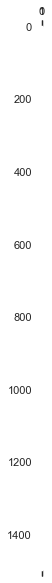

In [71]:
confusion_matrix = pd.crosstab(
    cv_labels,
    cv_pred,
    rownames=['True'],
    colnames=['Predicted'],
    margins=True
)
sns.set(rc={'figure.figsize':(6, 10)})
plt.spy(confusion_matrix, precision = 0.1, markersize = 2)

In [72]:
# REPEAT WITH ALL OTHER NODE KINDS 

# EXTRACT CORRECT CSV DATA

# DO IT AGAIN ON TEST SET